# Introduction : West Nile Virus
___

**Problem Statement**

1. Given weather, location, testing, and spraying data, predict when and where different species of mosquitos will test positive for West Nile virus. 
2. Is pesticide effective : Population before 2011 vs Population After 2013.


**Key variables**

|Data|Description|
|---|---|
|Id|Id of the Mosquito|
|Species|Species of Mosquito|
|Address|Location of Trap|
|Block| Block nunber of address|
|Street| Street Name|
|Trap ID| Id of Trap. Letter behind Trap ID indicate it is near a main Trap|
|Latitude , Longtitude|Location of Trap , Mosquito|
|NumMosquito| No. of Mosquito|
|WNV_Present| 1 means WNV is present, and 0 means not present|
|Spray CSV| Latitude , Longtitude. Dataset only at 2011, 2013|

**Model Explored**

**workflow**
1. EDA
2. Feature Engineering 
3. Data Preprocessing
4. Modelling to predict WNV probability (without pesticide)
5. Select best Model to study the effect of pesticide
  * 5.1 Hypothesis : Pesticide has no effect on Mosquito population

**Key Insight**

We need to derive an effective plan to deploy pesticides throughout the city, and that is exactly where you come in!  


In [1]:
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_train = pd.read_csv('./train.csv')
df_test = pd.read_csv('./test.csv')
df_spray = pd.read_csv('./spray.csv')
df_weather = pd.read_csv('./weather.csv')

In [3]:
# getting some basic information about each dataframe
# shape of dataframe i.e. number of rows and columns
# total number of rows with null values
# total number of duplicates
# data types of columns

def basic_eda(df, df_name):
    print(df_name.upper())
    print()
    print(f"Rows: {df.shape[0]} \t Columns: {df.shape[1]}")
    print()
    
    print(f"Total null rows: {df.isnull().sum().sum()}")
    print(f"Percentage null rows: {round(df.isnull().sum().sum() / df.shape[0] * 100, 2)}%")
    print()
    
    print(f"Total duplicate rows: {df[df.duplicated(keep=False)].shape[0]}")
    print(f"Percentage dupe rows: {round(df[df.duplicated(keep=False)].shape[0] / df.shape[0] * 100, 2)}%")
    print()
    
    print(df.dtypes)
    print("-----\n")

In [4]:
dfs = [
    (df_train, 'train'),
    (df_test, 'test'),
    (df_spray, 'spray'),
    (df_weather, 'weather')
    ]

In [5]:
[basic_eda(df, name) for df, name in dfs]

TRAIN

Rows: 10506 	 Columns: 12

Total null rows: 0
Percentage null rows: 0.0%

Total duplicate rows: 1062
Percentage dupe rows: 10.11%

Date                       object
Address                    object
Species                    object
Block                       int64
Street                     object
Trap                       object
AddressNumberAndStreet     object
Latitude                  float64
Longitude                 float64
AddressAccuracy             int64
NumMosquitos                int64
WnvPresent                  int64
dtype: object
-----

TEST

Rows: 116293 	 Columns: 11

Total null rows: 0
Percentage null rows: 0.0%

Total duplicate rows: 0
Percentage dupe rows: 0.0%

Id                          int64
Date                       object
Address                    object
Species                    object
Block                       int64
Street                     object
Trap                       object
AddressNumberAndStreet     object
Latitude                  fl

[None, None, None, None]

In [6]:
# what species are there ?
print(f'number of species: {df_train["Species"].nunique()}')
df_train["Species"].value_counts(normalize=True)

number of species: 7


CULEX PIPIENS/RESTUANS    0.452313
CULEX RESTUANS            0.260803
CULEX PIPIENS             0.256901
CULEX TERRITANS           0.021131
CULEX SALINARIUS          0.008186
CULEX TARSALIS            0.000571
CULEX ERRATICUS           0.000095
Name: Species, dtype: float64

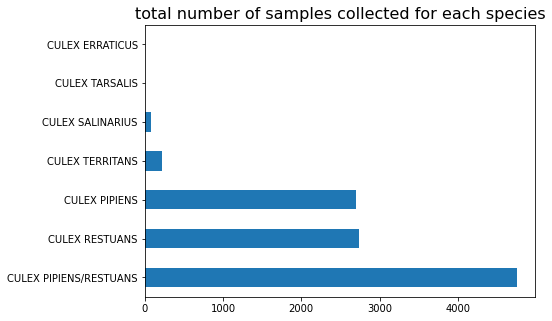

In [7]:
# look at the samples collected for each species
df_train['Species'].value_counts().plot(kind='barh', figsize=(7,5))
plt.title('total number of samples collected for each species', fontsize=16);

In [8]:
# calculate percentage
def percentage(part, whole):
    return round(100 * (part)/(whole), 2)

                        NumMosquitos  WnvPresent  Percentage "%"
Species                                                         
CULEX ERRATICUS                    7           0            0.00
CULEX PIPIENS                  44671         240            0.54
CULEX PIPIENS/RESTUANS         66268         262            0.40
CULEX RESTUANS                 23431          49            0.21
CULEX SALINARIUS                 145           0            0.00
CULEX TARSALIS                     7           0            0.00
CULEX TERRITANS                  510           0            0.00
-----------
WnvPresent data distribution: 
0    9955
1     551
Name: WnvPresent, dtype: int64


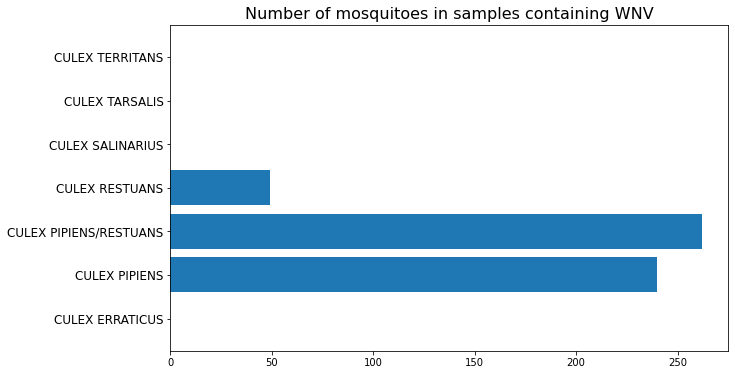

In [9]:
mos_wnv = df_train[['Species', 'NumMosquitos', 'WnvPresent']].groupby(by='Species').sum()
mos_wnv = pd.DataFrame(mos_wnv)
mos_wnv['Percentage "%"'] = percentage(mos_wnv['WnvPresent'], mos_wnv['NumMosquitos'])
print(mos_wnv)
print('-----------')
print(f'WnvPresent data distribution: \n{df_train.WnvPresent.value_counts()}')
mos_wnv.reset_index(inplace=True)
plt.figure(figsize=(10,6))
plt.barh(mos_wnv['Species'], mos_wnv['WnvPresent'])
plt.title('Number of mosquitoes in samples containing WNV', fontsize=16)
plt.yticks(fontsize=12)
plt.show()

T900     750
T115     542
T138     314
T002     185
T135     183
        ... 
T238       7
T076       5
T094B      5
T237       3
T040       2
Name: Trap, Length: 136, dtype: int64
------------

Number of unique traps: 136


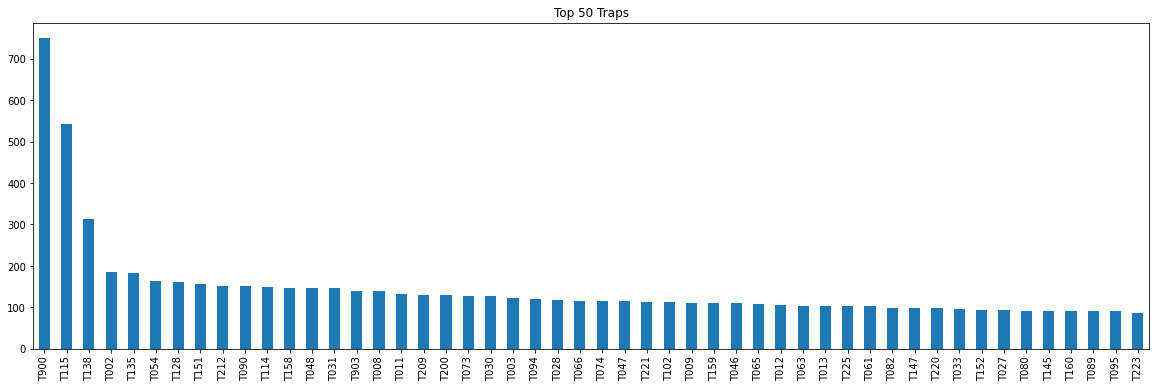

In [10]:
# look at trap distributions
print(df_train.Trap.value_counts())
df_train['Trap'].value_counts()[:50].plot(kind = 'bar' , figsize = (20,6))
plt.title('Top 50 Traps');
print('------------\n')
print(f'Number of unique traps: {df_train.Trap.nunique()}')

In [11]:
df_train[['Trap', 'NumMosquitos']].nunique()

Trap            136
NumMosquitos     50
dtype: int64

In [12]:
#combine mosquito counts

df_train = df_train.groupby([col for col in df_train.columns if col not in ['NumMosquitos', \
                                                                'WnvPresent']]).sum()
df_train.reset_index(inplace=True)
df_train['WnvPresent'] = df_train['WnvPresent'].map(lambda x : 1 if x > 0 else x)

df_train.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"1100 Roosevelt Road, Chicago, IL 60608, USA",CULEX PIPIENS/RESTUANS,11,W ROOSEVELT,T048,"1100 W ROOSEVELT, Chicago, IL",41.867108,-87.654224,8,1,0
1,2007-05-29,"1100 Roosevelt Road, Chicago, IL 60608, USA",CULEX RESTUANS,11,W ROOSEVELT,T048,"1100 W ROOSEVELT, Chicago, IL",41.867108,-87.654224,8,2,0
2,2007-05-29,"1100 South Peoria Street, Chicago, IL 60608, USA",CULEX RESTUANS,11,S PEORIA ST,T091,"1100 S PEORIA ST, Chicago, IL",41.862292,-87.648860,8,1,0
3,2007-05-29,"1100 West Chicago Avenue, Chicago, IL 60642, USA",CULEX RESTUANS,11,W CHICAGO,T049,"1100 W CHICAGO, Chicago, IL",41.896282,-87.655232,8,1,0
4,2007-05-29,"1500 North Long Avenue, Chicago, IL 60651, USA",CULEX RESTUANS,15,N LONG AVE,T153,"1500 N LONG AVE, Chicago, IL",41.907645,-87.760886,8,1,0


In [13]:
# duplicate the address
df_train[df_train.Trap=='T002']\
  .groupby(['AddressNumberAndStreet','Longitude','Latitude']).count()

,,,Date,Address,Species,Block,Street,Trap,AddressAccuracy,NumMosquitos,WnvPresent
AddressNumberAndStreet,Longitude,Latitude,,,,,,,,,
"4100 N OAK PARK AVE, Chicago, IL",-87.800991,41.95469,147,147,147,147,147,147,147,147,147


In [14]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8475 entries, 0 to 8474
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date                    8475 non-null   object 
 1   Address                 8475 non-null   object 
 2   Species                 8475 non-null   object 
 3   Block                   8475 non-null   int64  
 4   Street                  8475 non-null   object 
 5   Trap                    8475 non-null   object 
 6   AddressNumberAndStreet  8475 non-null   object 
 7   Latitude                8475 non-null   float64
 8   Longitude               8475 non-null   float64
 9   AddressAccuracy         8475 non-null   int64  
 10  NumMosquitos            8475 non-null   int64  
 11  WnvPresent              8475 non-null   int64  
dtypes: float64(2), int64(4), object(6)
memory usage: 794.7+ KB


# Cleaning data

In [15]:
# drop columns
def drop_address(df):
    address = ['Block', 'Street', 'AddressNumberAndStreet']
    df = df.drop(columns=address, inplace=True)
    return 

In [16]:
drop_address(df_train)

In [17]:
drop_address(df_test)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116293 entries, 0 to 116292
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Id               116293 non-null  int64  
 1   Date             116293 non-null  object 
 2   Address          116293 non-null  object 
 3   Species          116293 non-null  object 
 4   Trap             116293 non-null  object 
 5   Latitude         116293 non-null  float64
 6   Longitude        116293 non-null  float64
 7   AddressAccuracy  116293 non-null  int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 7.1+ MB


## Convert datetime column

In [18]:
#convert datetime

def datetime(df, name, column):
    df[column] = pd.to_datetime(df[column])
    
    # make datetime columns
    df['Year'] = df[column].apply(lambda x:x.year)
    df['Month'] = df[column].apply(lambda x:x.month)
    df['WeekofYear'] = df[column].apply(lambda x:x.weekofyear)
    df['YearMonth'] = df[column].apply(lambda x: '{}-{:02d}'.format(x.year, x.month))
    
    print(f'{name.upper()}:')
    print()
    
    # year 2007 - 2013
    print(df.Year.value_counts().sort_index())

    # data only from may - oct
    print(df.Month.value_counts())

    # week 22 - 41
    print(df.WeekofYear.value_counts().sort_index())

    # total number of weeks in dataset
    print(df.WeekofYear.nunique())
    print()
    
    print('----------\n')

In [19]:
df_list = [
    (df_train, 'train', 'Date'),
    (df_test, 'test', 'Date'),
    (df_spray, 'spray', 'Date'),
    (df_weather, 'weather', 'Date')
]

In [20]:
df_spray['Time'] = pd.to_datetime(df_spray['Time']).dt.time
[datetime(df, name, column) for df, name, column in df_list]

TRAIN:

2007    2775
2009    1915
2011    1773
2013    2012
Name: Year, dtype: int64
8     2750
7     2096
9     1947
6     1337
10     264
5       81
Name: Month, dtype: int64
22     81
23    343
24    283
25    292
26    408
27     85
28    821
29    465
30    567
31    800
32    599
33    596
34    669
35    350
36    343
37    481
38    606
39    422
40    244
41     20
Name: WeekofYear, dtype: int64
20

----------

TEST:

2008    30498
2010    36557
2012    27115
2014    22123
Name: Year, dtype: int64
7     25878
8     23277
9     19557
6     13415
2      6105
10     4897
5      4874
11     4850
3      3724
12     3660
1      3634
4      2422
Name: Month, dtype: int64
1     2423
2     1211
5     2433
6     2464
7     1208
10    3724
15    2422
18    1209
19    3665
23    1224
24    2423
25    4876
26    4892
28    4977
29    7405
30    9819
31    3677
32    2437
33    7366
34    7360
35    6114
36    2506
37    6118
38    7284
39    2433
40    2426
41    3687
44    1211
45    3639

[None, None, None, None]

## Sampling efforts per year

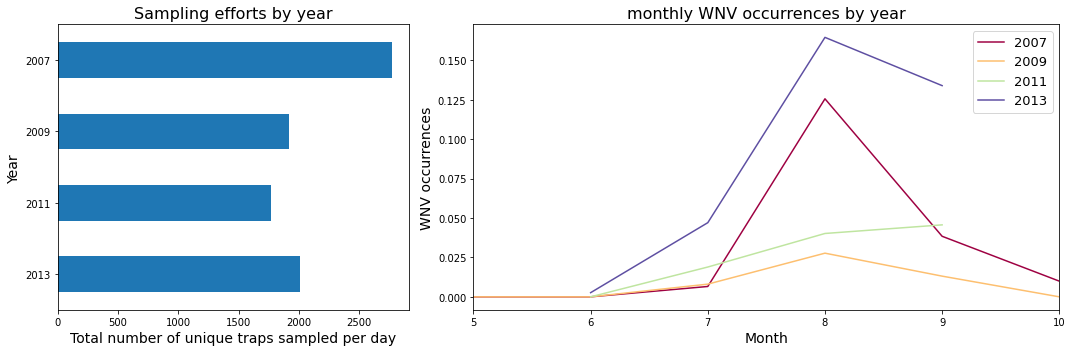

In [21]:
# sampling efforts per year

fig, ax = plt.subplots(ncols = 2, figsize=(15,5),  gridspec_kw={'width_ratios': [3, 5]})

# plot sampling efforts by year
df_train.Year.value_counts().sort_index(ascending=False).plot(kind = 'barh', ax = ax[0])
ax[0].set_title('Sampling efforts by year', fontsize=16)
ax[0].set_ylabel('Year',fontsize=14)
ax[0].set_xlabel('Total number of unique traps sampled per day',fontsize=14)

# plot WNV occurrence by month and year
wnv = df_train[['Date','WnvPresent','Year','Month']]
sns.lineplot(x = wnv.Month,y = 'WnvPresent', data = wnv, hue = 'Year', ci = None, 
             legend = 'full', palette = 'Spectral', ax = ax[1])
ax[1].legend(fontsize = 13)
ax[1].set_title('monthly WNV occurrences by year', fontsize=16)
ax[1].set_xlabel('Month',fontsize=14)
ax[1].set_ylabel('WNV occurrences',fontsize=14)
ax[1].set_xlim(wnv.Month.min(), wnv.Month.max())
plt.tight_layout()

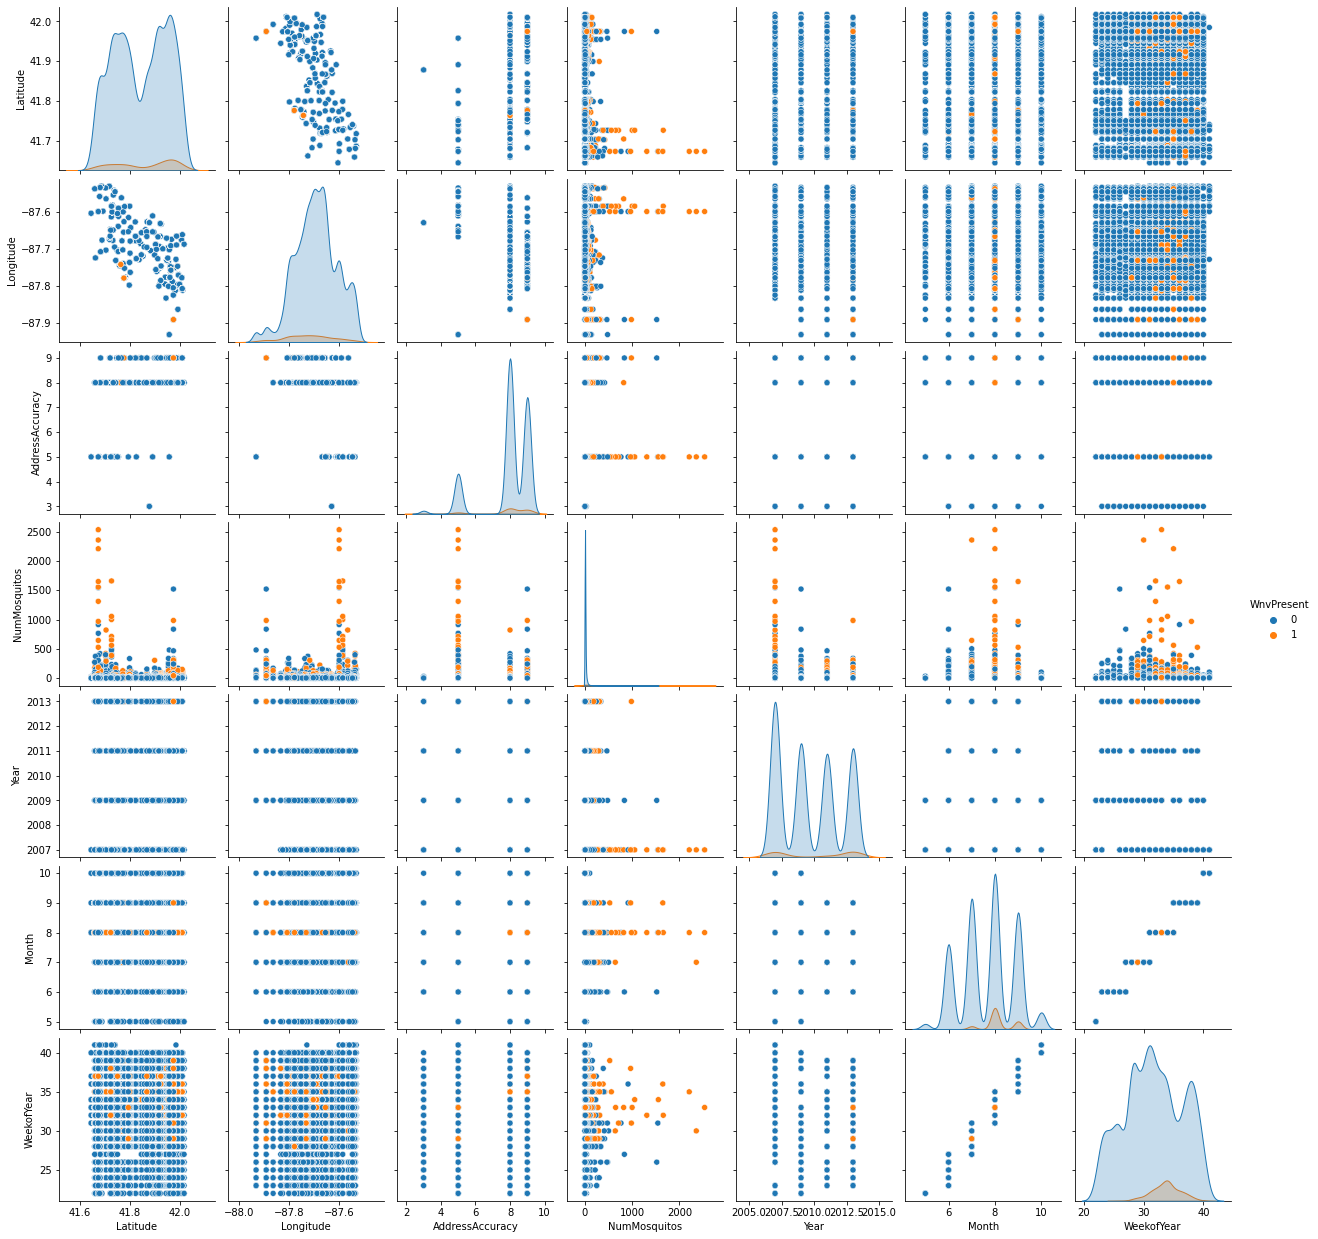

In [22]:
sns.pairplot(df_train, hue='WnvPresent');

In [23]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8475 entries, 0 to 8474
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             8475 non-null   datetime64[ns]
 1   Address          8475 non-null   object        
 2   Species          8475 non-null   object        
 3   Trap             8475 non-null   object        
 4   Latitude         8475 non-null   float64       
 5   Longitude        8475 non-null   float64       
 6   AddressAccuracy  8475 non-null   int64         
 7   NumMosquitos     8475 non-null   int64         
 8   WnvPresent       8475 non-null   int64         
 9   Year             8475 non-null   int64         
 10  Month            8475 non-null   int64         
 11  WeekofYear       8475 non-null   int64         
 12  YearMonth        8475 non-null   object        
dtypes: datetime64[ns](1), float64(2), int64(6), object(4)
memory usage: 860.9+ KB


## Mosquito counts per month

In [24]:
color_dict = dict({
            'CULEX PIPIENS':'tomato',
            'CULEX PIPIENS/RESTUANS':'orange',
            'CULEX RESTUANS': 'gold',
            'CULEX SALINARIUS': 'wheat',
            'CULEX TERRITANS': 'teal',
            'CULEX TARSALIS' : 'forestgreen',
            'CULEX ERRATICUS': 'dodgerblue'
          })


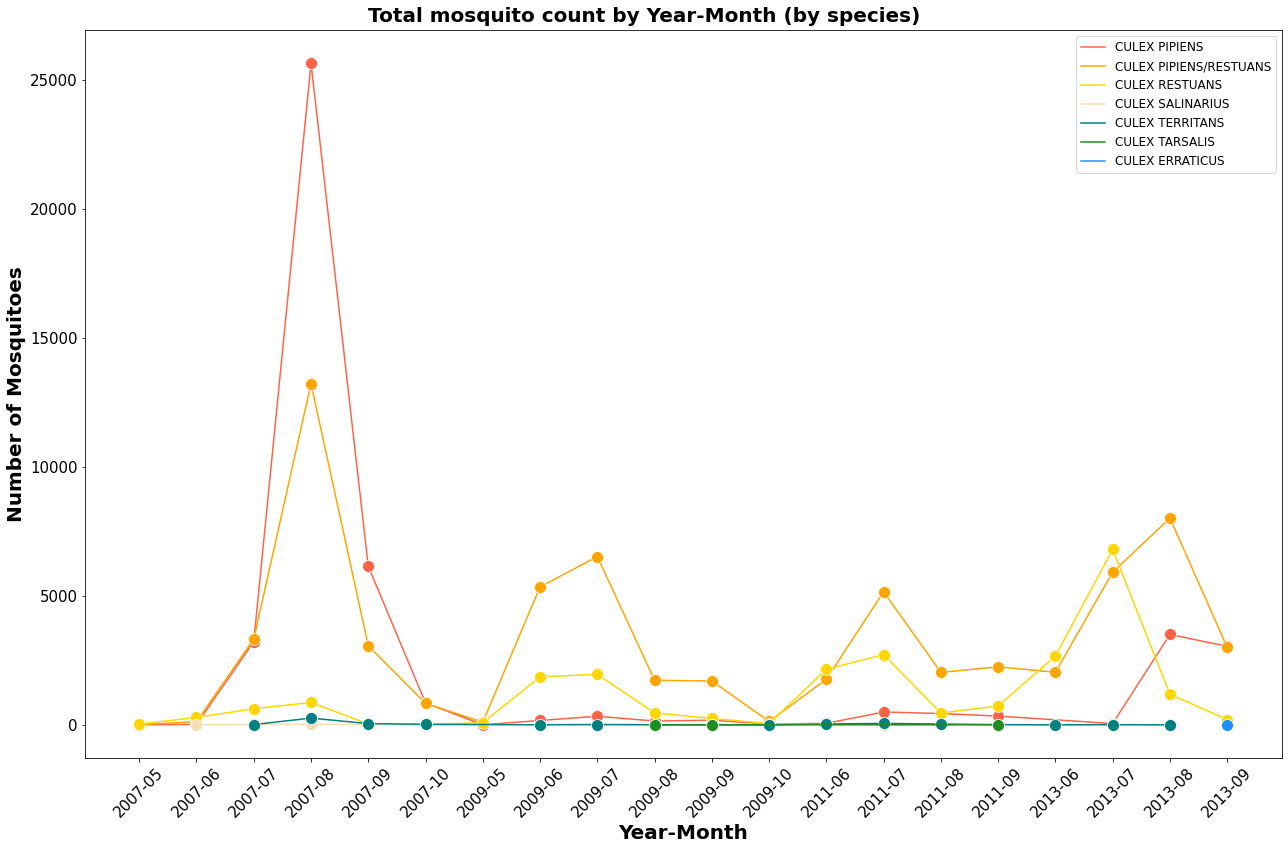

In [25]:
# plotting number of mosquitos per month, segregated by species

# creating a temporary df for our groupby view
temp_df = df_train.groupby(["YearMonth","Species"]).sum()

# since temp_df now is a multi-index df, we need to iterate through the index to pass `YearMonth` and `Species` to the plot  function
x_index = [keys for keys, values in temp_df.index]
hue_index = [values for keys, values in temp_df.index]

plt.figure(figsize=(18,12))

sns.lineplot(x = x_index,y = "NumMosquitos", data =temp_df.sort_index(level=0), marker='o', markersize=12, hue=hue_index, palette=color_dict)


plt.xlabel('Year-Month', fontweight='bold', fontsize='20', horizontalalignment='center')
plt.ylabel('Number of Mosquitoes', fontweight='bold', fontsize='20', horizontalalignment='center')

plt.tick_params(axis='both', which='major', labelsize=15)
plt.xticks(rotation=45)

title = "Total mosquito count by Year-Month (by species)"
plt.suptitle(title, fontweight='bold', fontsize='20', horizontalalignment='center')

plt.legend(fontsize='large', title_fontsize='20')


plt.tight_layout()

plt.savefig(title)

In [26]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8475 entries, 0 to 8474
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             8475 non-null   datetime64[ns]
 1   Address          8475 non-null   object        
 2   Species          8475 non-null   object        
 3   Trap             8475 non-null   object        
 4   Latitude         8475 non-null   float64       
 5   Longitude        8475 non-null   float64       
 6   AddressAccuracy  8475 non-null   int64         
 7   NumMosquitos     8475 non-null   int64         
 8   WnvPresent       8475 non-null   int64         
 9   Year             8475 non-null   int64         
 10  Month            8475 non-null   int64         
 11  WeekofYear       8475 non-null   int64         
 12  YearMonth        8475 non-null   object        
dtypes: datetime64[ns](1), float64(2), int64(6), object(4)
memory usage: 860.9+ KB


In [27]:
train_dummy = pd.get_dummies(columns =['Species', 'Trap', 'YearMonth'], data = df_train, drop_first=True)

In [28]:
df_weather.isin(['M']).sum()[df_weather.isin(['M']).sum() > 0].sort_values(ascending=False)

Water1         2944
Depart         1472
Depth          1472
SnowFall       1472
Tavg             11
Heat             11
Cool             11
SeaLevel          9
WetBulb           4
StnPressure       4
AvgSpeed          3
PrecipTotal       2
dtype: int64

In [29]:
# replace trace and missing precip with 0s
df_weather.PrecipTotal.replace(['  T','M'],0,inplace=True)
df_weather.PrecipTotal = df_weather.PrecipTotal.astype(float)

# check number of rows with missing avg temp
print(df_weather.Tavg.value_counts()['M'])

# imputing Tavg manually (increases accuracy)
df_weather.Tavg = (df_weather.Tmax + df_weather.Tmin)/2
df_weather.Tavg = df_weather.Tavg.astype(float)

11


In [30]:
df_weather.drop(['Water1','Depart','Depth','SnowFall','AvgSpeed','ResultSpeed','ResultDir','SeaLevel','StnPressure','CodeSum','Heat','Cool'],axis=1,inplace=True)

In [31]:
merged_df = pd.merge(df_weather, train_dummy, on=['Date', 'Year', 'WeekofYear', 'Month'])

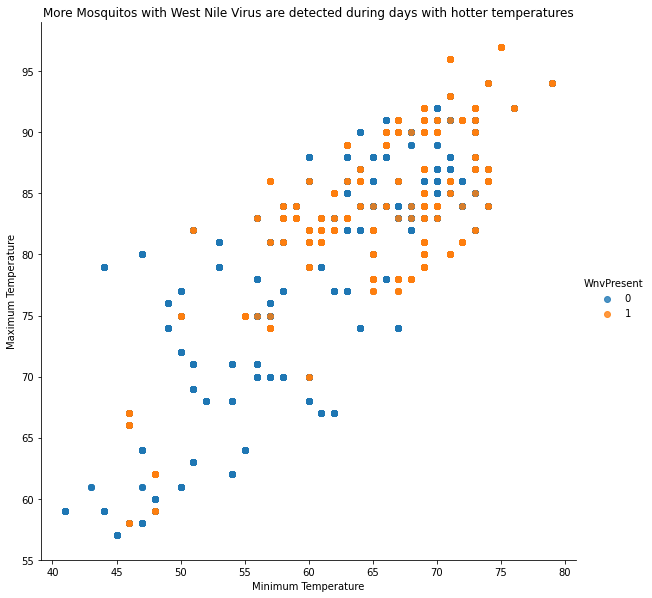

In [32]:
sns.lmplot( x='Tmin', y='Tmax', data=merged_df, fit_reg=False, hue='WnvPresent', height=8)
plt.title('More Mosquitos with West Nile Virus are detected during days with hotter temperatures')
plt.xlabel('Minimum Temperature')
plt.ylabel('Maximum Temperature');

In [33]:
merged_df['NumMosquitos'] = merged_df['NumMosquitos'].fillna(0)

In [34]:
merged_df['WnvPresent'] = merged_df['WnvPresent'].fillna(0)

In [35]:
merged_df.isin(['-']).sum()[merged_df.isin(['-']).sum() > 0].sort_values(ascending=False)

Sunrise    8475
Sunset     8475
dtype: int64

In [36]:
merged_df['Sunrise'] = np.where(merged_df['Sunrise'].isin(['-']),0,merged_df['Sunrise'])
merged_df['Sunset'] = np.where(merged_df['Sunset'].isin(['-']),0,merged_df['Sunset'])
merged_df['WetBulb'] = np.where(merged_df['Sunset'].isin(['-']),0,merged_df['Sunset'])


In [37]:
df_train_new = merged_df.iloc[:len(df_train) :]

In [38]:
df_weather_new = merged_df.iloc[:len(df_weather) :]

In [39]:
df_merged_new = pd.concat([df_train_new, df_weather_new], axis=0)

In [40]:
X = df_merged_new.drop(['Date','WnvPresent'], axis=1)
y = df_merged_new['WnvPresent']

In [42]:
!pip install plot_metric

## Train test split

In [43]:
import warnings
warnings.simplefilter(action='ignore')
# imports
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix, classification_report, plot_roc_curve, roc_auc_score, 
accuracy_score, precision_score, recall_score, f1_score, auc, precision_recall_curve, average_precision_score)
from sklearn.datasets import make_classification
from plot_metric.functions import BinaryClassification
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA

In [44]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8475 entries, 0 to 8474
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             8475 non-null   datetime64[ns]
 1   Address          8475 non-null   object        
 2   Species          8475 non-null   object        
 3   Trap             8475 non-null   object        
 4   Latitude         8475 non-null   float64       
 5   Longitude        8475 non-null   float64       
 6   AddressAccuracy  8475 non-null   int64         
 7   NumMosquitos     8475 non-null   int64         
 8   WnvPresent       8475 non-null   int64         
 9   Year             8475 non-null   int64         
 10  Month            8475 non-null   int64         
 11  WeekofYear       8475 non-null   int64         
 12  YearMonth        8475 non-null   object        
dtypes: datetime64[ns](1), float64(2), int64(6), object(4)
memory usage: 860.9+ KB


In [45]:
X = train_dummy.drop(columns=['WnvPresent', 'Date', 'Address'])
y = train_dummy['WnvPresent']

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6356, 167), (2119, 167), (6356,), (2119,))

## Use SMOTE to deal with imbalanced data

In [47]:
# Do scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

(6356, 2)
(6356,)
<class 'numpy.ndarray'> <class 'pandas.core.series.Series'>


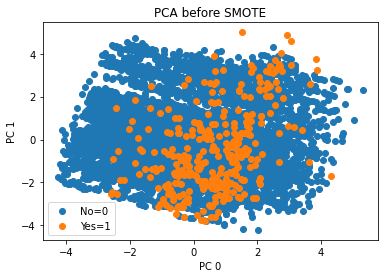

In [48]:
# Do PCA before and after SMOTE to see effects
pca_2d_before = PCA(n_components=2)
pca_2d_before.fit(X_train)
Z_train_pca_2d_before = pca_2d_before.transform(X_train)

print(Z_train_pca_2d_before.shape)
print(y_train.shape)
print(type(Z_train_pca_2d_before), type(y_train))

mask0 = (y_train == 0)
mask1 = (y_train == 1)

fig, ax = plt.subplots()

# ax.scatter(Z[:, 0], Z[:, 1]) # Z[:, 0] - first col, Z[:, 1], 2nd col

# numpy slicing arr[row, col]
ax.scatter(Z_train_pca_2d_before[mask0, 0], Z_train_pca_2d_before[mask0, 1], label='No=0')
ax.scatter(Z_train_pca_2d_before[mask1, 0], Z_train_pca_2d_before[mask1, 1], label='Yes=1')

ax.set_xlabel('PC 0')
ax.set_ylabel('PC 1')
ax.set_title('PCA before SMOTE')
ax.legend()
plt.show()

In [49]:
# Use smote to deal with imbalance data
from imblearn.over_sampling import SMOTE
import imblearn

sm = SMOTE(random_state=2)
X_train, y_train = sm.fit_resample(X_train, y_train)
print(X_train.shape, y_train.shape)
print(type(X_train), type(y_train))

(12026, 167) (12026,)
<class 'numpy.ndarray'> <class 'pandas.core.series.Series'>


In [50]:
y_train.sum()

6013

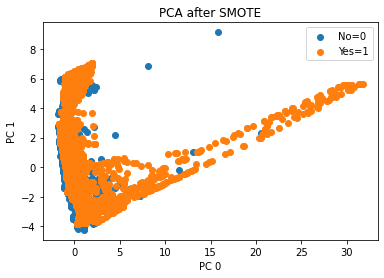

In [51]:
# pca
pca_2d = PCA(n_components=2)
pca_2d.fit(X_train)
Z_train_pca_2d = pca_2d.transform(X_train)

mask0 = (y_train == 0)
mask1 = (y_train == 1)

fig, ax = plt.subplots()

# numpy slicing arr[row, col]
ax.scatter(Z_train_pca_2d[mask0, 0], Z_train_pca_2d[mask0, 1], label='No=0')
ax.scatter(Z_train_pca_2d[mask1, 0], Z_train_pca_2d[mask1, 1], label='Yes=1')

ax.set_xlabel('PC 0')
ax.set_ylabel('PC 1')
ax.set_title('PCA after SMOTE')
ax.legend()
plt.show()


In [52]:
num_input_features = len(X)
num_input_features

8475

In [53]:
y_train.value_counts()

0    6013
1    6013
Name: WnvPresent, dtype: int64

# Preprocessing and Modelling

In [60]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix, classification_report, plot_roc_curve, roc_auc_score, 
accuracy_score, precision_score, recall_score, f1_score, auc, precision_recall_curve, average_precision_score)
from sklearn.datasets import make_classification
from plot_metric.functions import BinaryClassification
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC

In [61]:
# Instiantiate models
models = {'lr': LogisticRegression(max_iter=5_000, random_state=42, solver='saga'),
          'rf': RandomForestClassifier(random_state=42),
          'gb': GradientBoostingClassifier(random_state=42),
          'dt': DecisionTreeClassifier(random_state=42),
          'et': ExtraTreesClassifier(random_state=42),
          'ada': AdaBoostClassifier(random_state=42),
          'svc': SVC(random_state=42, probability=True),
        }

In [62]:
# Instantiate lists to store results
init_list = []
gs_list = []

# Function to run model -- input scaler and model
def run_model(mod, mod_params={}, grid_search=False):
    
    # Initial dictionary to hold model results
    results = {}
    
    pipe = Pipeline([
            ('ss', StandardScaler()),
            (mod, models[mod])
            ])
    
    if grid_search:
        # Instantiate list to store gridsearch results
        gs = GridSearchCV(pipe, param_grid=mod_params, cv=3, verbose=1, scoring='roc_auc', n_jobs=-1)
        gs.fit(X_train, y_train)
        pipe = gs
        
    else:
        pipe.fit(X_train, y_train)
    
    # Retrieve metrics
    predictions = pipe.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    y_test_pred_prob = pipe.predict_proba(X_test)[:,1]
    y_train_pred_prob = pipe.predict_proba(X_train)[:,1]
    
    results['model'] = mod
    results['train_auc'] = roc_auc_score(y_train, y_train_pred_prob)
    results['test_auc'] = roc_auc_score(y_test, y_test_pred_prob)
    results['precision'] = precision_score(y_test, predictions)
    results['specificity'] = tn / (tn + fp)
    results['recall'] = recall_score(y_test, predictions)
    results['f_score'] = f1_score(y_test, predictions)
    
    if grid_search:
        gs_list.append(results)
        print('### BEST PARAMS ###')
        display(pipe.best_params_)
        
    else:
        init_list.append(results)
    
    print('### METRICS ###')
    display(results)
    
    print(f"True Negatives: {tn}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"True Positives: {tp}")
    
    return pipe

In [63]:
def evaluation_plot(model,prediction_list,proba_list):
  train_pred,test_pred = prediction_list
  train_proba,test_proba = proba_list
  plt.figure(figsize=(24,12))
  bc = BinaryClassification(y_train, train_proba[::,1], labels=["WNV-", "WNV+"])
  bc1 = BinaryClassification(y_test, test_proba[::,1], labels=["WNV-", "WNV+"])
  #plotting ROC-AUC curve
  plt.subplot2grid(shape=(3,12), loc=(0,0), colspan=3)
  bc.plot_roc_curve(title = 'Training - ROC')
  plt.subplot2grid(shape=(3,12), loc=(0,3), colspan=3)
  bc1.plot_roc_curve(title  = 'Testing - ROC')
  #plotting Precission-recall curve
  plt.subplot2grid((3,12), (1,0), colspan=3)
  bc.plot_precision_recall_curve(title = 'Training - Precision -Recall Curve')
  plt.subplot2grid((3,12), (1,3), colspan=3)
  bc1.plot_precision_recall_curve(title = 'Testing - Precision -Recall Curve')
  #plot confusion matrix
  plt.subplot2grid((3,12), (0,6), colspan=3)
  bc.plot_confusion_matrix(title ='Training')
  plt.subplot2grid((3,12), (0,9), colspan=3)
  bc1.plot_confusion_matrix(title = 'Testing')
  #plot confusion matrix with the values normalized
  plt.subplot2grid((3,12), (1,6), colspan=3)
  bc.plot_confusion_matrix(title ='Training' , normalize = True)
  plt.subplot2grid((3,12), (1,9), colspan=3)
  bc1.plot_confusion_matrix(title = 'Testing', normalize = True)
  #plot class distribution
  plt.subplot2grid((3,12), (2,3), colspan=3)
  bc.plot_class_distribution(title ='Training -Class Distribution')
  plt.subplot2grid((3,12), (2,6), colspan=3)
  bc1.plot_class_distribution(title = 'Testing - Class Distribution')
  plt.show()  
  bc.print_report()

In [67]:
def predictions(pipeline):
    pipeline.fit(X_train,y_train) #fit pipeline to training data
    a = [pipeline.predict(X_train), 
 #      pipeline.predict(X_val.values),
       pipeline.predict(X_test)]
    b = [pipeline.predict_proba(X_train),
 #      pipeline.predict_proba(X_val.values),
       pipeline.predict_proba(X_test)]
    return a,b

In [68]:
lr = run_model('lr')

### METRICS ###


{'model': 'lr',
 'train_auc': 0.9289527881120369,
 'test_auc': 0.8483178019862624,
 'precision': 0.19080459770114944,
 'specificity': 0.8244389027431421,
 'recall': 0.7280701754385965,
 'f_score': 0.302367941712204}

True Negatives: 1653
False Positives: 352
False Negatives: 31
True Positives: 83


In [69]:
prediction_list,proba_list= predictions(lr)

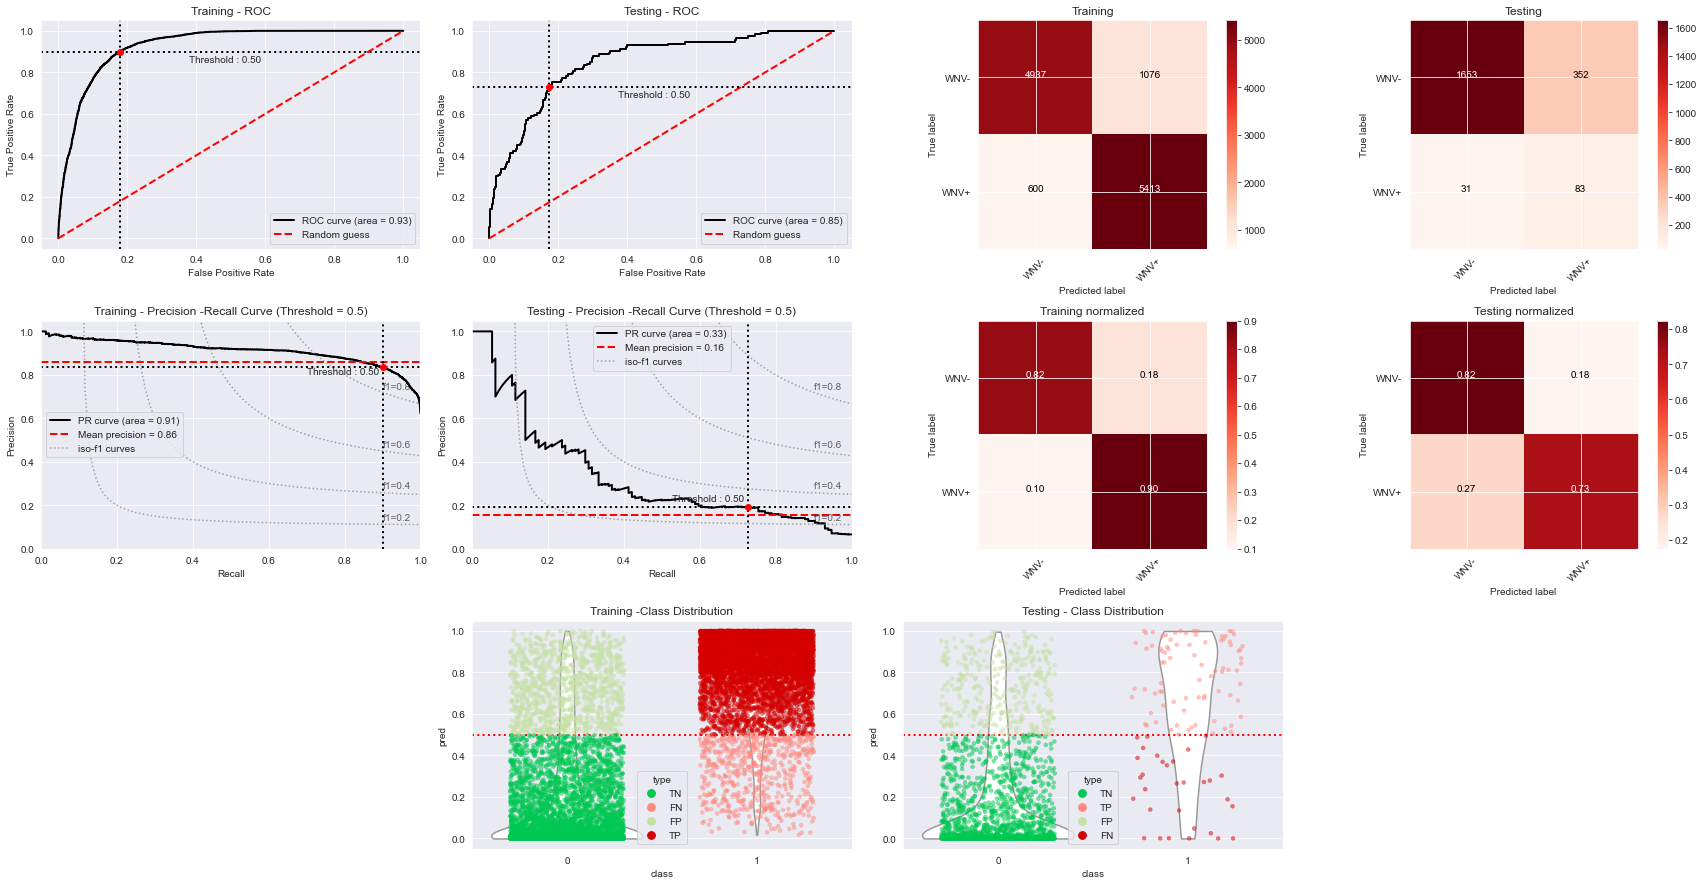

                   ________________________
                  |  Classification Report |
                   ‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
              precision    recall  f1-score   support

        WNV-       0.89      0.82      0.85      6013
        WNV+       0.83      0.90      0.87      6013

    accuracy                           0.86     12026
   macro avg       0.86      0.86      0.86     12026
weighted avg       0.86      0.86      0.86     12026



In [70]:
evaluation_plot(lr, prediction_list,proba_list)

In [71]:
rf = run_model('rf')

### METRICS ###


{'model': 'rf',
 'train_auc': 0.9999999446844051,
 'test_auc': 0.8908802555015969,
 'precision': 0.39285714285714285,
 'specificity': 0.9745635910224439,
 'recall': 0.2894736842105263,
 'f_score': 0.33333333333333337}

True Negatives: 1954
False Positives: 51
False Negatives: 81
True Positives: 33


In [72]:
prediction_list,proba_list= predictions(rf)

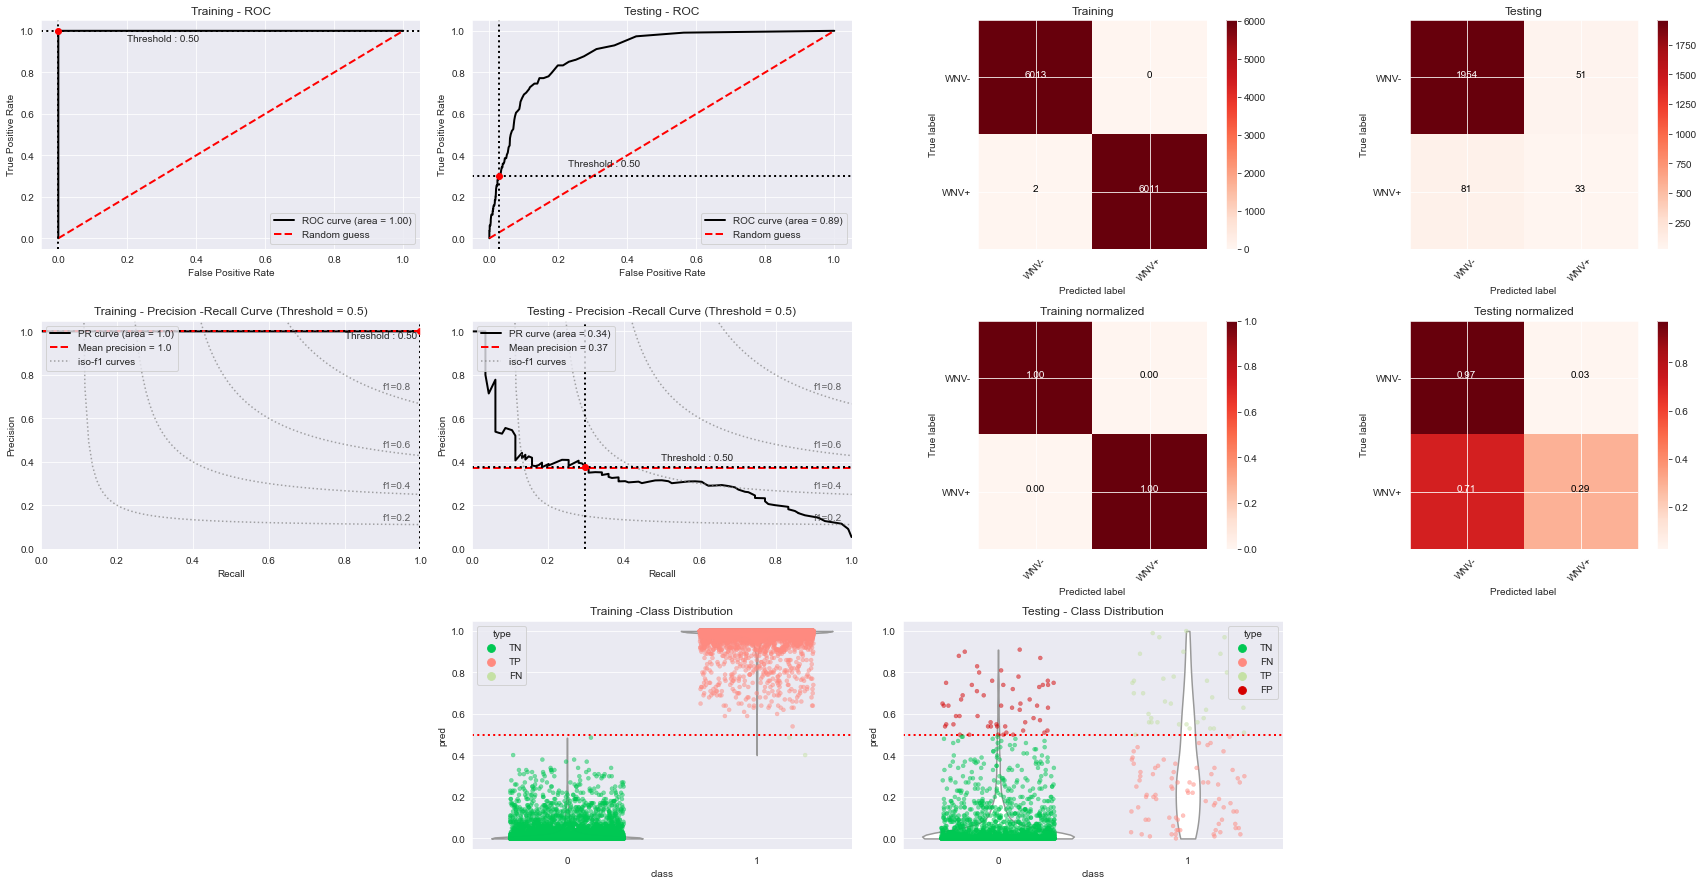

                   ________________________
                  |  Classification Report |
                   ‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
              precision    recall  f1-score   support

        WNV-       1.00      1.00      1.00      6013
        WNV+       1.00      1.00      1.00      6013

    accuracy                           1.00     12026
   macro avg       1.00      1.00      1.00     12026
weighted avg       1.00      1.00      1.00     12026



In [73]:
evaluation_plot(rf, prediction_list,proba_list)

In [74]:
gb = run_model('gb')

### METRICS ###


{'model': 'gb',
 'train_auc': 0.9918674459122038,
 'test_auc': 0.8968631053944087,
 'precision': 0.34,
 'specificity': 0.9341645885286783,
 'recall': 0.5964912280701754,
 'f_score': 0.4331210191082803}

True Negatives: 1873
False Positives: 132
False Negatives: 46
True Positives: 68


In [75]:
prediction_list,proba_list= predictions(gb)

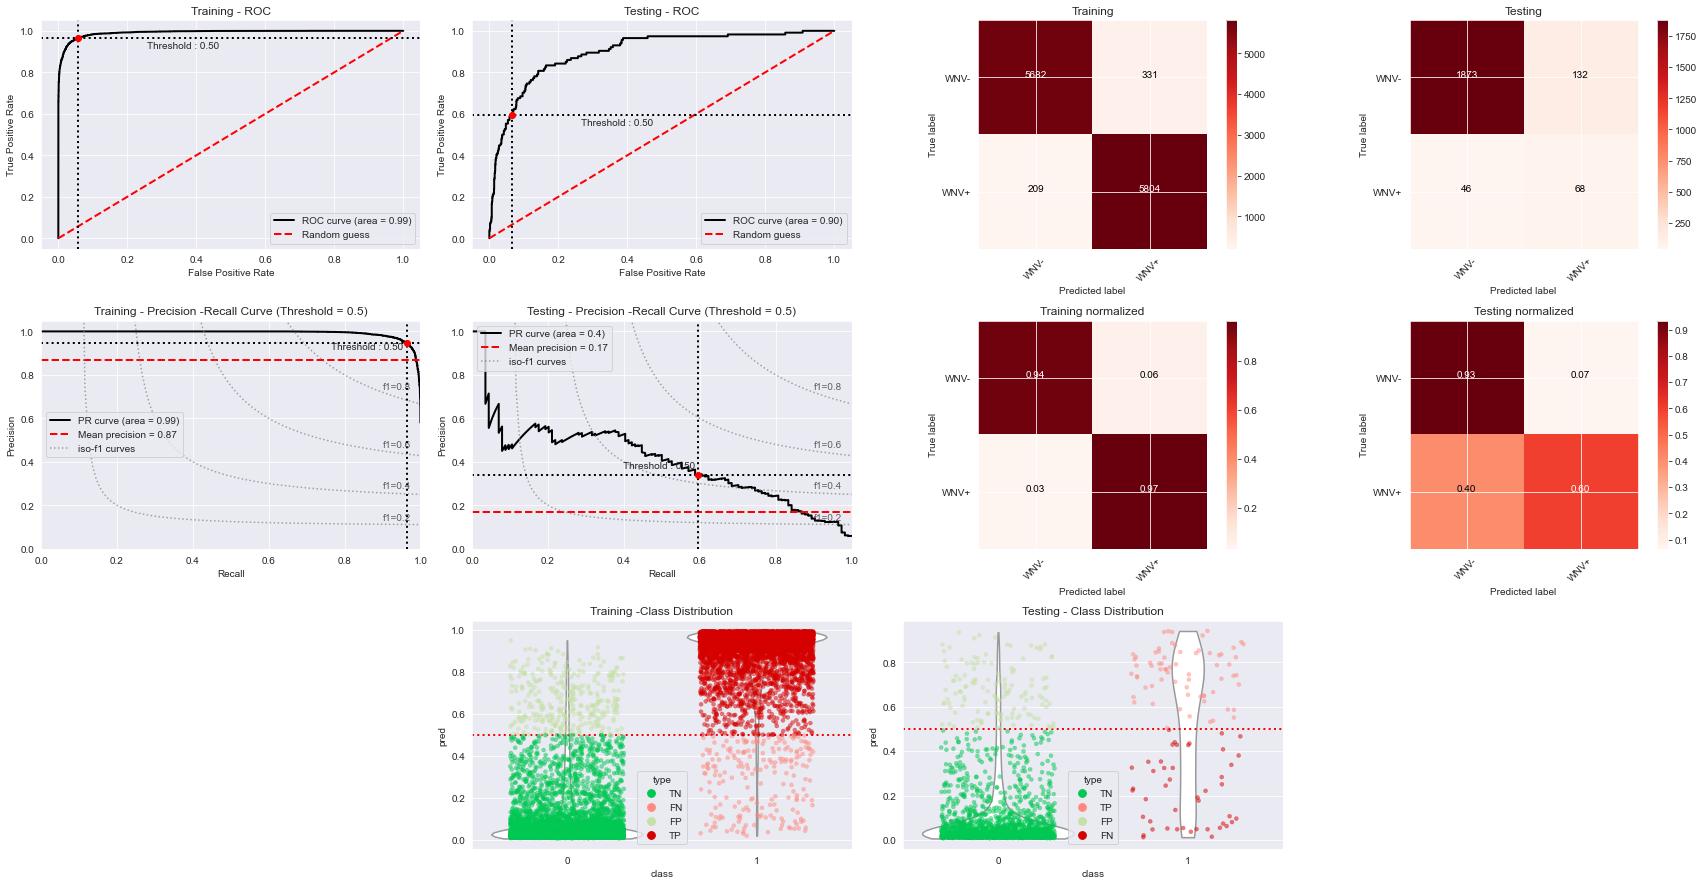

                   ________________________
                  |  Classification Report |
                   ‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
              precision    recall  f1-score   support

        WNV-       0.96      0.94      0.95      6013
        WNV+       0.95      0.97      0.96      6013

    accuracy                           0.96     12026
   macro avg       0.96      0.96      0.96     12026
weighted avg       0.96      0.96      0.96     12026



In [76]:
evaluation_plot(gb, prediction_list,proba_list)

In [77]:
dt = run_model('dt')

### METRICS ###


{'model': 'dt',
 'train_auc': 0.999999944684405,
 'test_auc': 0.6244345277157982,
 'precision': 0.2556390977443609,
 'specificity': 0.9506234413965087,
 'recall': 0.2982456140350877,
 'f_score': 0.27530364372469635}

True Negatives: 1906
False Positives: 99
False Negatives: 80
True Positives: 34


In [78]:
prediction_list,proba_list= predictions(dt)

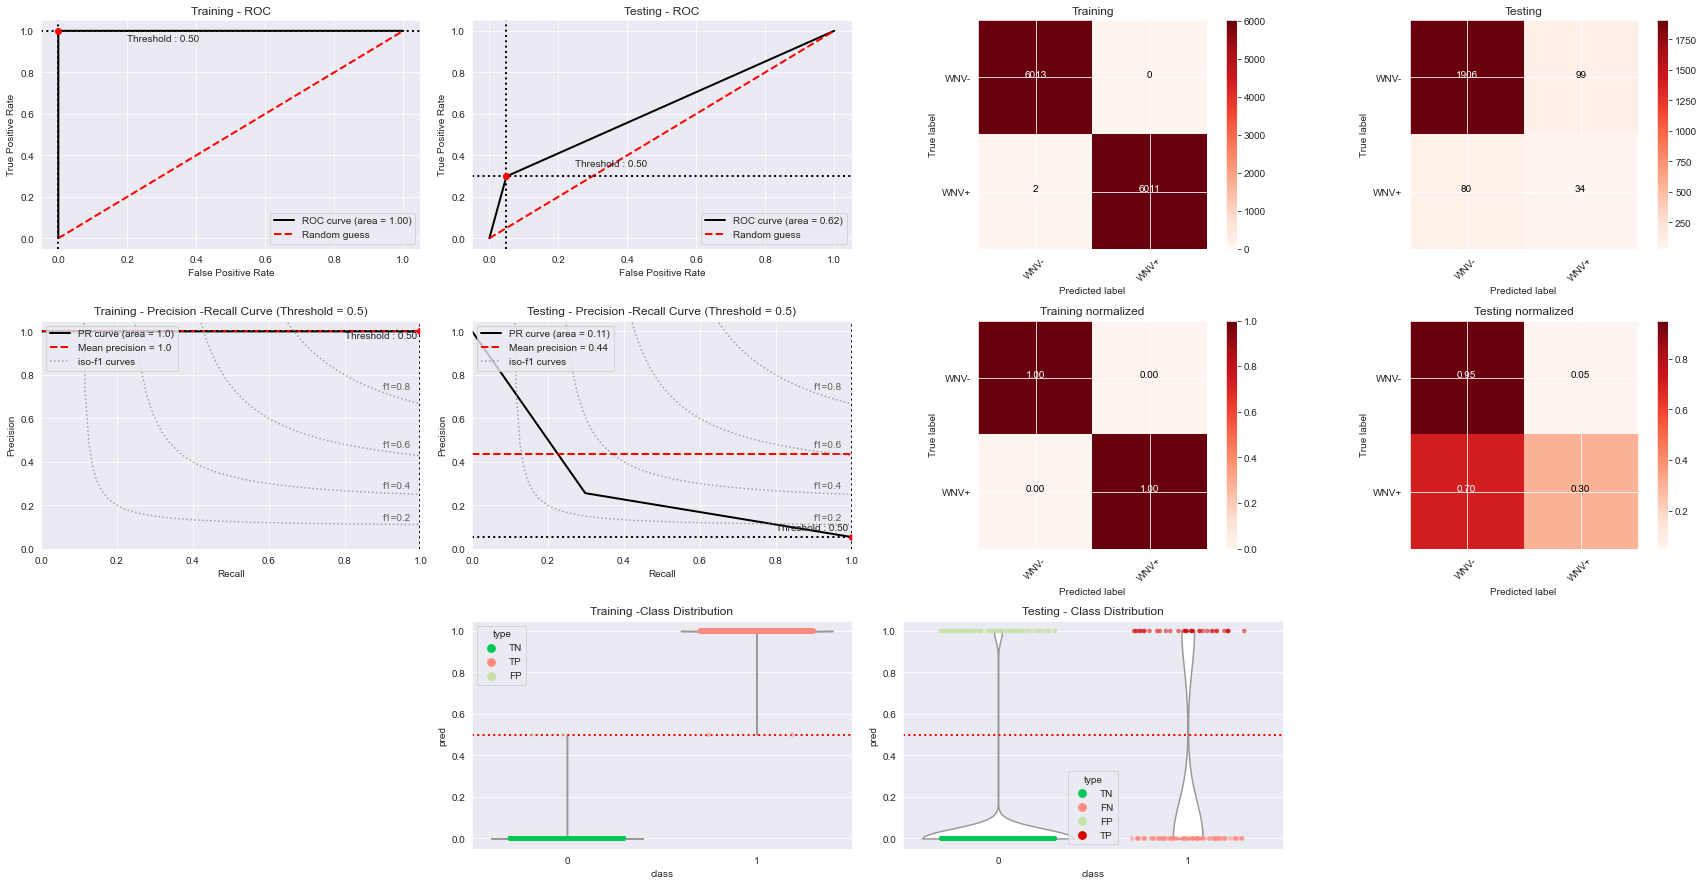

                   ________________________
                  |  Classification Report |
                   ‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
              precision    recall  f1-score   support

        WNV-       1.00      1.00      1.00      6013
        WNV+       1.00      1.00      1.00      6013

    accuracy                           1.00     12026
   macro avg       1.00      1.00      1.00     12026
weighted avg       1.00      1.00      1.00     12026



In [79]:
evaluation_plot(dt, prediction_list,proba_list)

In [80]:
et = run_model('et')

### METRICS ###


{'model': 'et',
 'train_auc': 0.999999944684405,
 'test_auc': 0.8467012293826837,
 'precision': 0.27956989247311825,
 'specificity': 0.9665835411471322,
 'recall': 0.22807017543859648,
 'f_score': 0.251207729468599}

True Negatives: 1938
False Positives: 67
False Negatives: 88
True Positives: 26


In [81]:
prediction_list,proba_list= predictions(et)

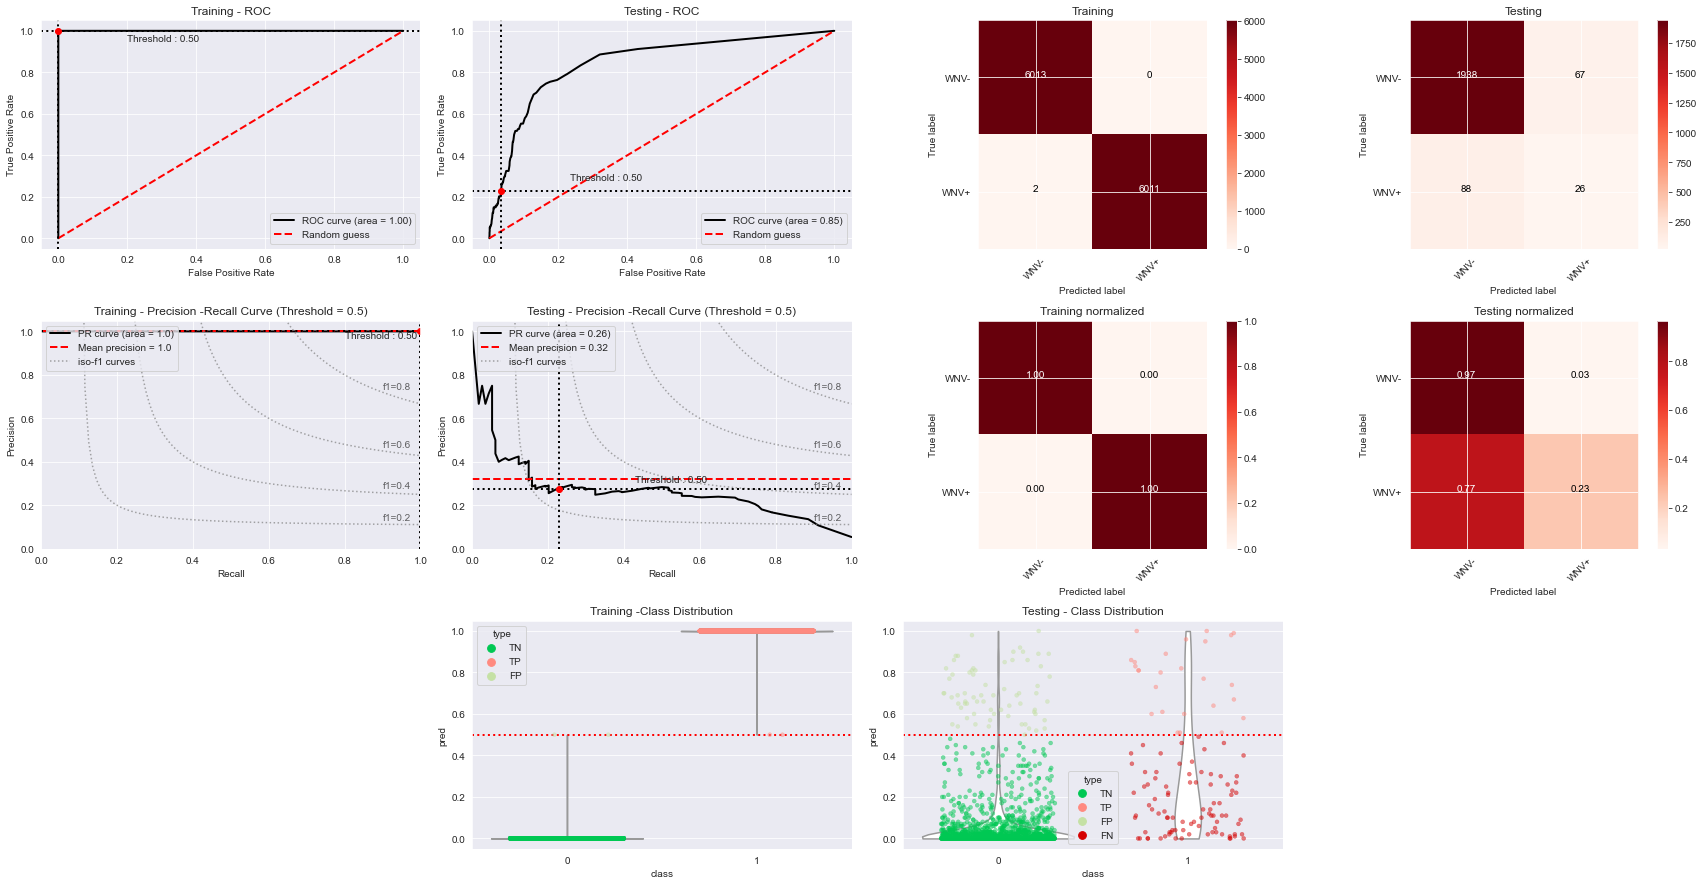

                   ________________________
                  |  Classification Report |
                   ‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
              precision    recall  f1-score   support

        WNV-       1.00      1.00      1.00      6013
        WNV+       1.00      1.00      1.00      6013

    accuracy                           1.00     12026
   macro avg       1.00      1.00      1.00     12026
weighted avg       1.00      1.00      1.00     12026



In [82]:
evaluation_plot(et, prediction_list,proba_list)

In [83]:
ada = run_model('ada')

### METRICS ###


{'model': 'ada',
 'train_auc': 0.9831398481404375,
 'test_auc': 0.8986284289276808,
 'precision': 0.2967479674796748,
 'specificity': 0.913715710723192,
 'recall': 0.6403508771929824,
 'f_score': 0.40555555555555556}

True Negatives: 1832
False Positives: 173
False Negatives: 41
True Positives: 73


In [84]:
prediction_list,proba_list= predictions(ada)

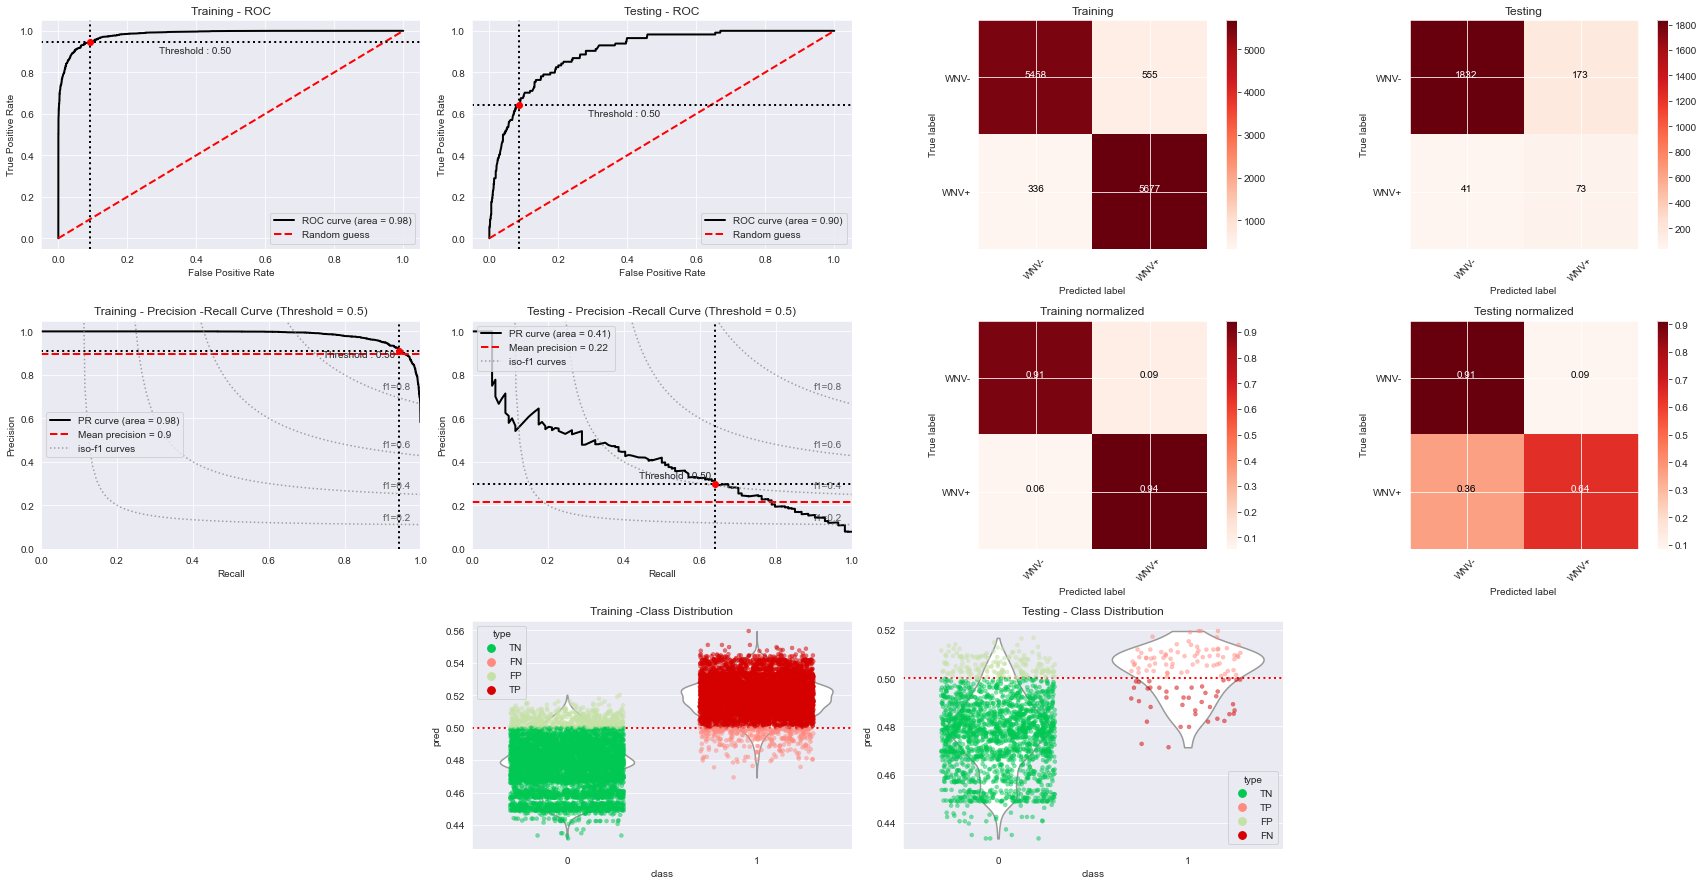

                   ________________________
                  |  Classification Report |
                   ‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
              precision    recall  f1-score   support

        WNV-       0.94      0.91      0.92      6013
        WNV+       0.91      0.94      0.93      6013

    accuracy                           0.93     12026
   macro avg       0.93      0.93      0.93     12026
weighted avg       0.93      0.93      0.93     12026



In [85]:
evaluation_plot(ada, prediction_list,proba_list)

In [86]:
svc = run_model('svc')

### METRICS ###


{'model': 'svc',
 'train_auc': 0.9812980186036857,
 'test_auc': 0.8193988712429452,
 'precision': 0.17405063291139242,
 'specificity': 0.8698254364089776,
 'recall': 0.4824561403508772,
 'f_score': 0.2558139534883721}

True Negatives: 1744
False Positives: 261
False Negatives: 59
True Positives: 55


In [87]:
prediction_list,proba_list= predictions(svc)

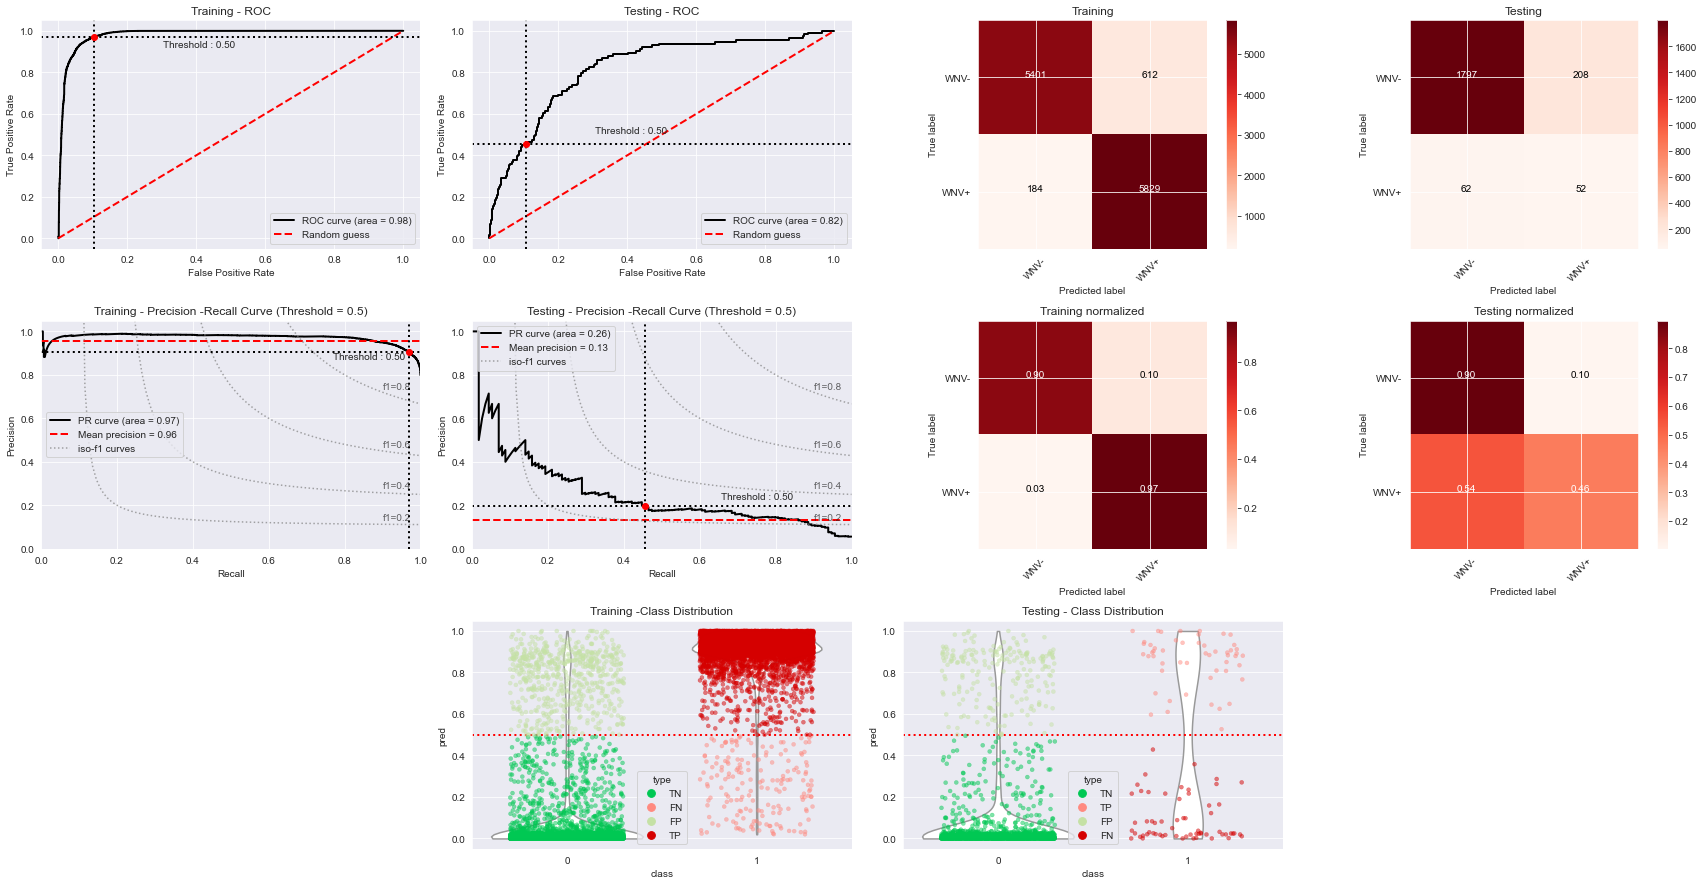

                   ________________________
                  |  Classification Report |
                   ‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
              precision    recall  f1-score   support

        WNV-       0.97      0.90      0.93      6013
        WNV+       0.90      0.97      0.94      6013

    accuracy                           0.93     12026
   macro avg       0.94      0.93      0.93     12026
weighted avg       0.94      0.93      0.93     12026



In [88]:
evaluation_plot(svc, prediction_list,proba_list)

In [89]:
# Results of our initial modelling
pd.DataFrame(init_list).sort_values(by='test_auc', ascending=False).reset_index(drop=True)

,model,train_auc,test_auc,precision,specificity,recall,f_score
0,ada,0.983140,0.898628,0.296748,0.913716,0.640351,0.405556
1,gb,0.991867,0.896863,0.340000,0.934165,0.596491,0.433121
2,rf,1.000000,0.890880,0.392857,0.974564,0.289474,0.333333
3,lr,0.928953,0.848318,0.190805,0.824439,0.728070,0.302368
4,lr,0.928953,0.848318,0.190805,0.824439,0.728070,0.302368
5,et,1.000000,0.846701,0.279570,0.966584,0.228070,0.251208
6,svc,0.981298,0.819399,0.174051,0.869825,0.482456,0.255814
7,dt,1.000000,0.624435,0.255639,0.950623,0.298246,0.275304


In [90]:
init_dict = {
    lr: 'LogisticRegression',
    gb: 'GradientBoostingClassifier',
    ada: 'AdaBoostClassifier',
    rf: 'RandomForest',
    svc: 'SupportVectorMachineCl',
    et: 'ExtraTrees',
    dt: 'DecisionTreeClassifier',
}

In [91]:
def roc_curve_plotter(model_dict, plot_top=False):
    fig, ax = plt.subplots(1, 1, figsize=(12,10))
    axes = {}
    for i, m in enumerate(model_dict.keys()):
        axes[f'ax{i}'] = plot_roc_curve(m, X_test, y_test, ax=ax, name=model_dict[m])
    if plot_top:
        for i, a in enumerate(axes):
            if i != 0:
                axes[a].line_.set_color('lightgrey')
    plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--', label='Random Guess')
    plt.title('ROC-AUC Curve Comparison', fontsize=22)
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.legend(fontsize=12)

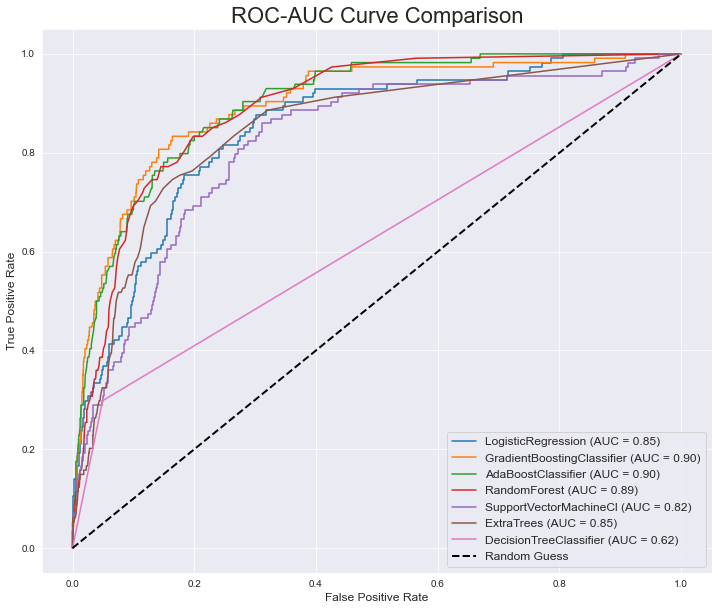

In [92]:
roc_curve_plotter(init_dict)